In [2]:
import pandas as pd
import numpy as np

In [3]:
stats = pd.read_csv("data/models/stats.csv")

# sort by number of topics
stats = stats.sort_values(by="Num_Topics", ascending=False)


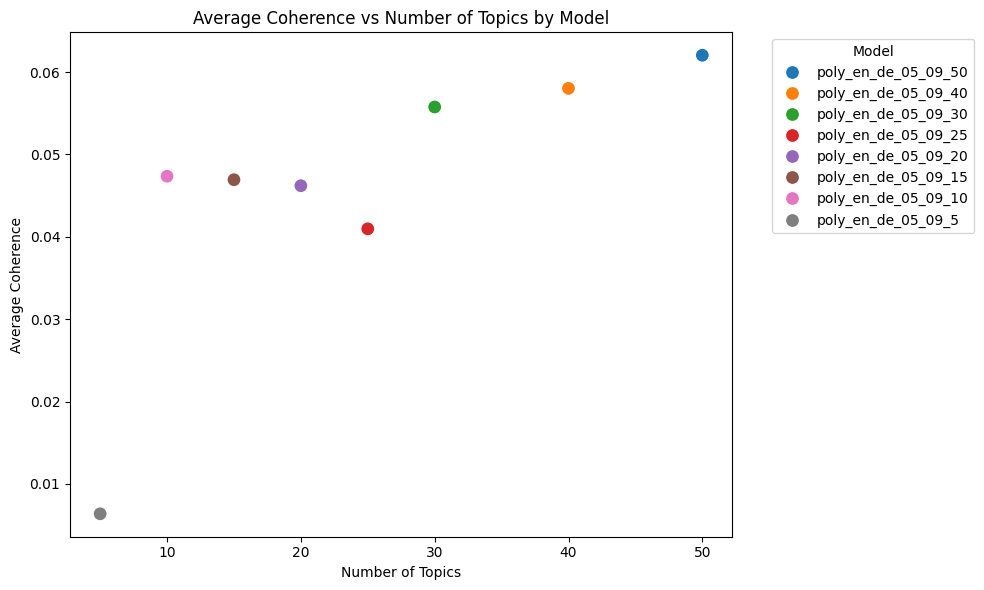

In [4]:
# plot Average_Coherence vs  Num_Topics
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.scatterplot(data=stats, x="Num_Topics", y="Average_Coherence", hue="Model", s=100)
plt.title("Average Coherence vs Number of Topics by Model")
plt.xlabel("Number of Topics")
plt.ylabel("Average Coherence")
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [13]:
from pathlib import Path
from scipy import sparse
from dotenv import dotenv_values

model_path = Path("data/models/wiki/ende/poly_en_de_05_09_25")
source_path = Path("/export/usuarios_ml4ds/lbartolome/Repos/alonso_mind/Data/polylingual_df.parquet")
env_path = ".env"
open_api_key = dotenv_values(env_path).get("OPEN_API_KEY", None)

In [14]:
def get_doc_top_tpcs(doc_distr, topn=2):
    sorted_tpc_indices = np.argsort(doc_distr)[::-1]
    top = sorted_tpc_indices[:topn].tolist()
    top_weight = [(k, doc_distr[k]) for k in top]
    return top_weight

In [15]:
def get_most_representative_per_tpc(mat, topn=10, thr=None):
    # Find the most representative document for each topic based on a matrix mat
    top_docs_per_topic = []
    
    mat_ = mat.copy()
    
    if thr:
        mat_[mat_ > thr] = 0

    print(f"Threshold: {thr}")
    for doc_distr in mat_.T:
        sorted_docs_indices = np.argsort(doc_distr)[::-1]
        top = sorted_docs_indices[:topn].tolist()
        top_docs_per_topic.append(top)
    return top_docs_per_topic

In [16]:
from mind.prompter.prompter import Prompter
from mind.utils.utils import load_prompt


prompter = Prompter(
    model_type="gpt-4o-2024-08-06",
    openai_key=open_api_key
)

prompt = load_prompt("src/mind/pipeline/prompts/topic_label.txt")

mind.prompter.prompter - INFO - Using OpenAI API with model: gpt-4o-2024-08-06
mind.prompter.prompter - INFO - Setting OpenAI API key from argument.


Loaded config file config/config.yaml and section logger.
Logs will be saved in data/logs
Loaded config file config/config.yaml and section llm.


In [17]:
df = pd.read_parquet(source_path)
df["len"] = df['lemmas'].apply(lambda x: len(x.split()))

# Load thetas
thetas_en = sparse.load_npz(model_path / "mallet_output" / "thetas_EN.npz").toarray()
s3_en = sparse.load_npz(model_path / "mallet_output" / "s3_EN.npz").toarray()

raw_en = df[df.chunk_id.str.contains("EN")].copy()
raw_en["thetas"] = list(thetas_en)
raw_en["top_k"] = raw_en["thetas"].apply(get_doc_top_tpcs)

# get most representative documents per topic based on S3
top_docs_per_topic_en = get_most_representative_per_tpc(thetas_en, topn=5, thr=0)

with open(model_path / "mallet_output" / "keys_EN.txt", 'r') as file: lines = file.readlines()
topic_keys = [line.strip() for line in lines]
    
tpc_labels = []
for id_tpc, tpc in enumerate(topic_keys):
    this_tpc_prompt = prompt.format(keywords=tpc, docs="\n"+"\n".join(raw_en.iloc[top_docs_per_topic_en[id_tpc]].text.values.tolist()))
    print(f"Topic: {tpc}")

    response, _ = prompter.prompt(
        question=this_tpc_prompt,
    )
        
    print(response)
    
    #import pdb; pdb.set_trace()
    tpc_labels.append(response)
    print(f"Label: {response}")

# save labels
with open(model_path / "mallet_output" / "tpc_labels.txt", 'w') as file:
    file.write("\n".join(tpc_labels))

Threshold: 0
Topic: river florida west land north border technology county lake united south water mile include virginia east region delaware canada
Geographical Regions and Waterways
Label: Geographical Regions and Waterways
Topic: trump bush president clinton obama ford campaign office house presidential ultrasound election january white presidency official percent donald report
U.S. Presidential Politics
Label: U.S. Presidential Politics
Topic: franklin write hamilton john jefferson lincoln poe technology washington thomas publish health organization adams benjamin philadelphia james york time
American Historical Figures and Literature
Label: American Historical Figures and Literature
Topic: church religious technology book catholic prayer anglican religion communion god common christ christian eucharistic lord bread service faith supper
Christian Communion Practices
Label: Christian Communion Practices
Topic: health organization lafayette french day king paris technology louis july